# Argosim tutorial - Part 3

In this tutorial we will explore the `imaging_utils` module. This module provides functions to simulate radio images.

In [402]:
# Import the imaging module
from argosim.imaging_utils import *

## Sky and UV spaces


What is the link between the sky space and the uv space?
- Fourrier Transform

- In radio interferometry, observations of the sky are not directly obtained as images. Instead, interferometers measure visibilities, which are samples of the Fourier transform of the sky image in the UV plane (spatial frequency domain).

Sky space (image plane): Represents the intensity of the radio signal as a function of angular position in the sky.

UV space (spatial frequency plane): Represents the visibilities, which are the Fourier coefficients of the sky image.
 

Which functions of the `imaging_utils` module are used to convert between the sky and uv spaces? How do the work internally?

- sky2uv(sky)


### Loading a sky image
We will use `PIL.Image` to load the `png` images and `numpy` to convert the image to a numpy array. 

P.S. The `PIL` library is not installed in the Argosim environment. You can install it by running the following command:
```bash
!pip install pillow
```

In [403]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [404]:
# Load the Cygnus A image
sky_model_path = '../data/sky_models/cygnus_a.png'
sky_png = Image.open(sky_model_path)

# Convert the image to a numpy array
sky = np.array(sky_png)

# Check the array shape
print(sky.shape)


(541, 541, 2)


Does it have the shape we expect? no there is 2 channels

What do you have to say about the size of the image? (Hint: remember what the functions sky2uv and uv2sky do.)

it suggests that the image have two channels, instead of one. howeever, Argosim expects a 2D image (single channel).To fix this, we need to extract only one channel from the image.


(541, 541)


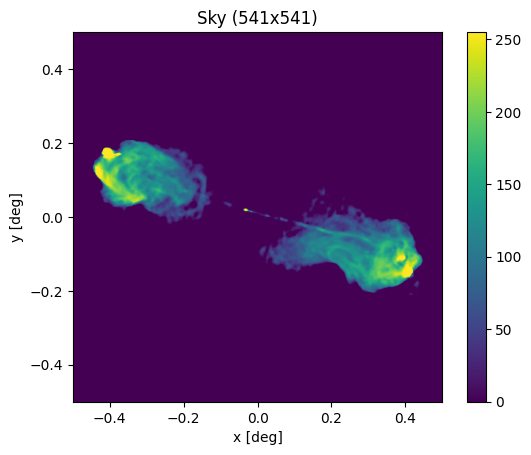

In [405]:
from argosim import plot_utils

# Argosim works with 2D images, with just one channel. Get rid of the unnecessary dimensions.

sky = sky[:, :, 0] 

# Check the new shape
print(sky.shape)  

# Plot the sky image
plot_utils.plot_sky(sky, fov_size=(1.0, 1.0), ax=None, fig=None, title='Sky')




### UV space

In [406]:
# Convert the sky model to uv space and analyze the result

from argosim.imaging_utils import sky2uv

# Convert the sky model to UV space
sky_uv = sky2uv(sky)

# Check the size and data type
print(sky_uv.shape, sky_uv.dtype)


(541, 541) complex128


What is the size of the output array? Which type of data does it contain?
...

- the size of the output array should be the same than the inputs so : (541, 541) 

- the array contains complex values, representing the amplitude and phase of spatial frequencies in the UV plane


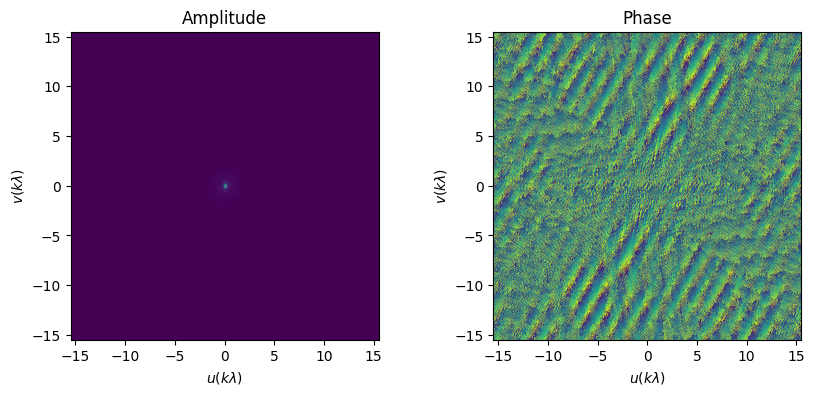

In [407]:
# Plot the sky model in uv space
plot_utils.plot_sky_uv(sky_uv, fov_size=(1.0, 1.0))




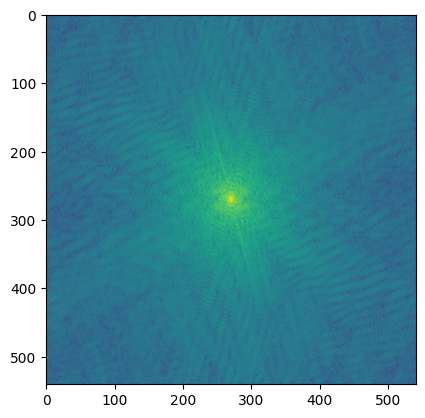

In [408]:
plt.imshow(np.log(np.abs(sky_uv)))


### Repeat for the other sky models

(512, 512)
(512, 512) complex128


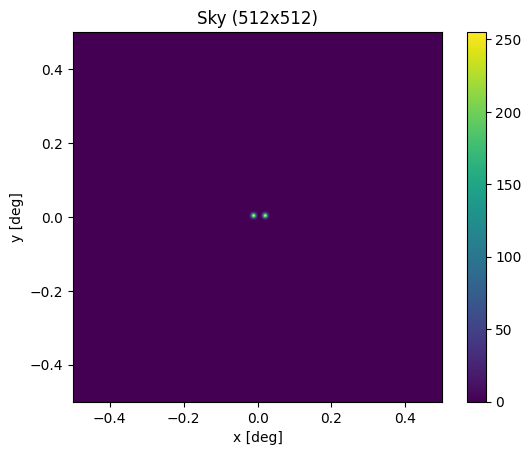

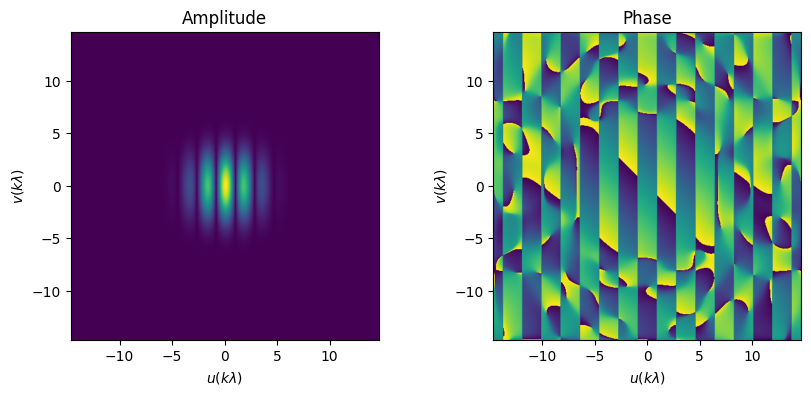

In [409]:
# Import other sky model

sky_model_path = '../data/sky_models/double_narrow.png'
sky_png = Image.open(sky_model_path)

# Convert the image to a numpy array
sky = np.array(sky_png)

# Check the array shape
print(sky.shape)

#plot sky model
plot_utils.plot_sky(sky, fov_size=(1.0, 1.0), ax=None, fig=None, title='Sky')

# Convert the sky model to UV space
sky_uv = sky2uv(sky)

# Check the size and data type
print(sky_uv.shape, sky_uv.dtype)

# Plot the sky model in uv space
plot_utils.plot_sky_uv(sky_uv, fov_size=(1.0, 1.0))



## Imaging


Recall the imaging process. What are the steps involved? How do we simulate the observed sky model given the uv coverage (uv sampling points)?

...

In [410]:
from argosim.antenna_utils import *
from argosim import antenna_utils, plot_utils
from argosim import imaging_utils

In [411]:
# Load the data
dataset = np.load('../data/sky_models/galsim_sky.npy', allow_pickle=True)[()]

# Check dataset keys
print(dataset.keys())  # Should print: dict_keys(['image', 'field_area_arcmin2'])

# Get the sky model image
sky = dataset['image']

# Compute field of view size (convert arcmin² to degrees)
fov_size = np.sqrt(dataset['field_area_arcmin2']) / 60.0



dict_keys(['image', 'gal_pos', 'star_pos', 'g1', 'g2', 'star_g1', 'star_g2', 'star_flux', 'n_galaxies', 'n_stars', 'field_area_arcmin2'])


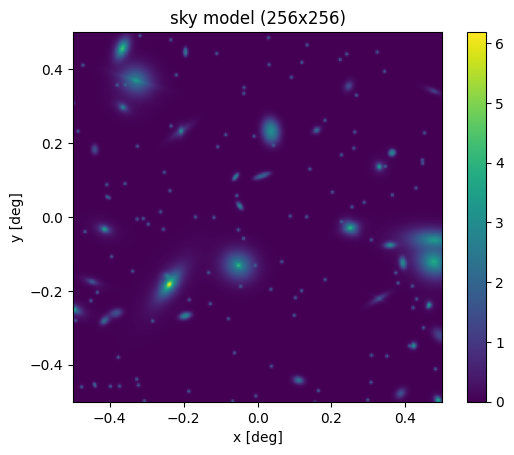

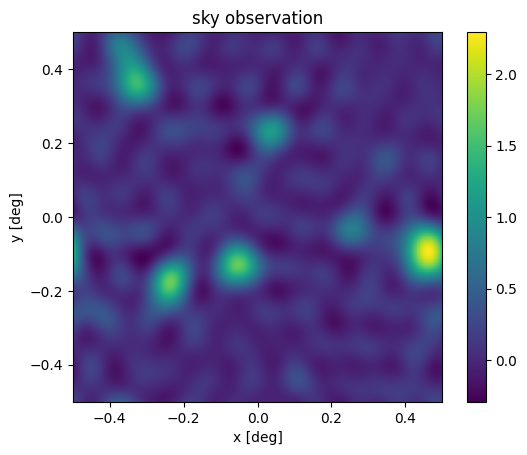

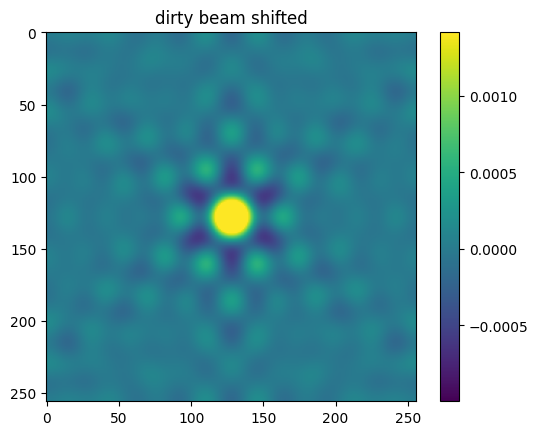

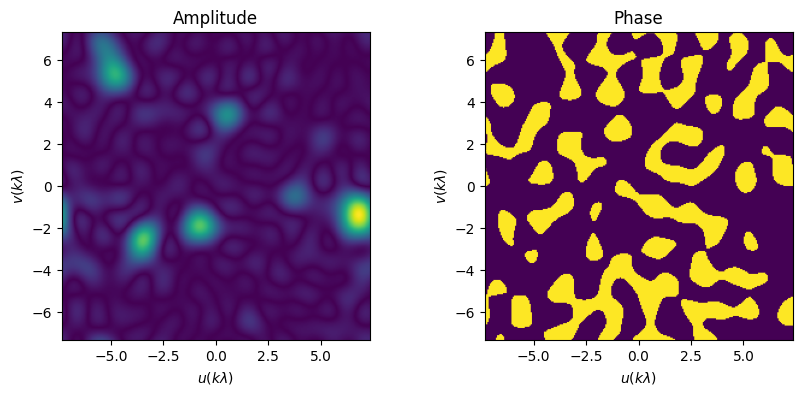

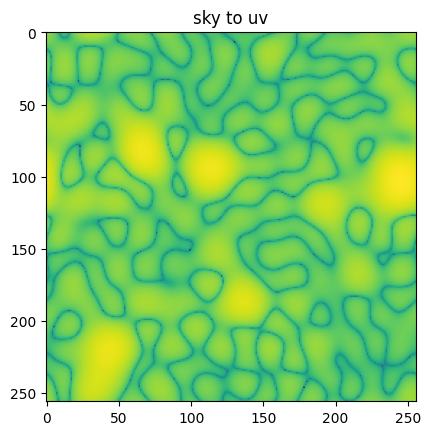

In [421]:

# Get the sky model image and the asociated field of view size
sky = dataset['image']
fov_size = np.sqrt(dataset['field_area_arcmin2'])/60.0

# Set up the antenna array, compute the baselines and the uv tracks
antena = antenna_utils.y_antenna_arr(n_antenna=1000, r=10e3)

baselines = antenna_utils.get_baselines(antena)
track, _= antenna_utils.uv_track_multiband(baselines)


# Perform the observation
obs, dirty_beam = imaging_utils.simulate_dirty_observation(sky, track, fov_size)


plot_utils.plot_sky(sky, title="sky model")

plot_utils.plot_sky(obs)

plt.title('sky observation')

dirty_beam_shifted = np.fft.fftshift(dirty_beam)
plot_utils.plot_beam(dirty_beam_shifted)
plt.title('dirty beam shifted')


plot_utils.plot_sky_uv(obs, fov_size=(1.0, 1.0))
plt.title('sky to uv')

plt.imshow(np.log(np.abs(obs)))


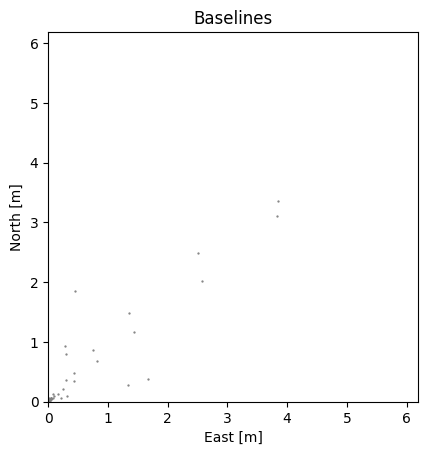

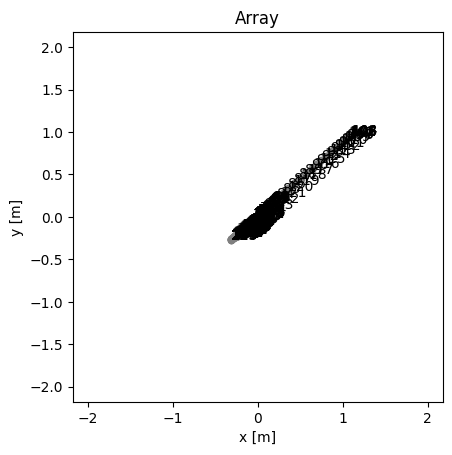

In [422]:
plot_utils.plot_baselines(sky, ENU=True)
plot_utils.plot_antenna_arr(obs)



In [423]:
import argosim
print(dir(argosim.imaging_utils)) 



['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add_noise_uv', 'compute_visibilities_grid', 'grid_uv_samples', 'local_seed', 'np', 'rnd', 'simulate_dirty_observation', 'sky2uv', 'uv2sky']


Text(0.5, 1.0, 'sky observation')

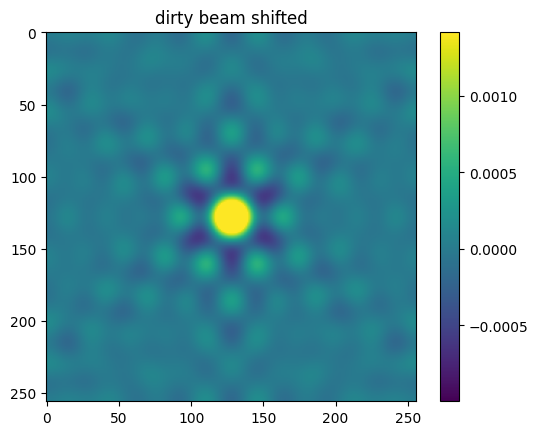

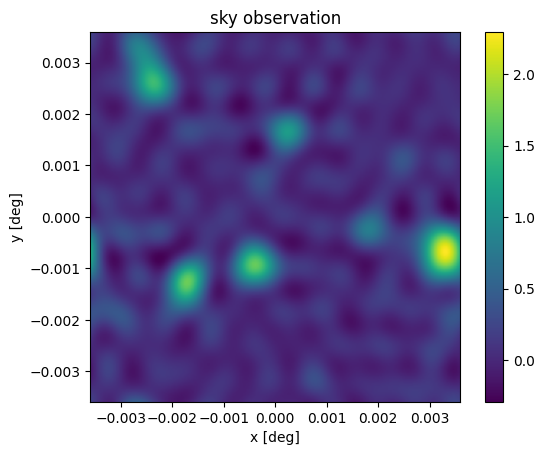

In [424]:
fov_size = (fov_size, fov_size)  

# Plot the dirty beam
dirty_beam_shifted = np.fft.fftshift(dirty_beam)
plot_utils.plot_beam(dirty_beam_shifted)
plt.title('dirty beam shifted')

# Plot the observation

plot_utils.plot_sky(obs, fov_size=fov_size)
plt.title('sky observation')


Reached threshold at iteration 10


Text(0.5, 1.0, 'cleaned image')

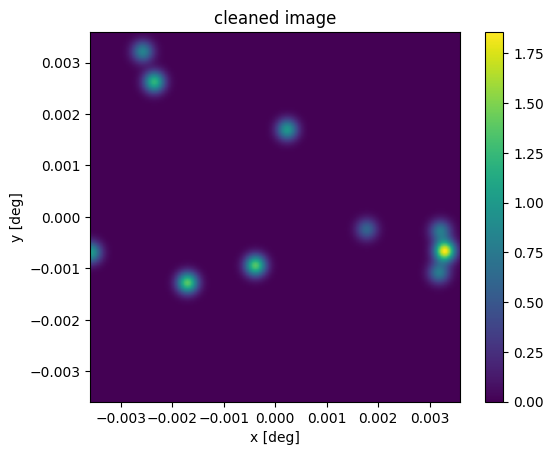

In [425]:
from argosim.clean import *
I_clean, sky__model = clean_hogbom(obs, dirty_beam, gamma=0.8, max_iter=100, threshold=10e-2 , clean_beam_size_px=12, res=False)

# Plot the clean image
plot_utils.plot_sky(I_clean, fov_size)
plt.title('cleaned image')

metric: {'mse': np.float64(0.10596751565493712), 'residual': array([[2.92963372e-03, 3.00650857e-03, 3.14663234e-03, ...,
        3.10126114e+00, 2.03776884e+00, 9.27197635e-01],
       [3.23743210e-03, 3.90755385e-03, 4.44134185e-03, ...,
        3.17907643e+00, 1.89661300e+00, 7.80535936e-01],
       [3.77506041e-03, 3.98417376e-03, 4.39477433e-03, ...,
        2.28680110e+00, 1.22612262e+00, 5.15729725e-01],
       ...,
       [5.28052390e-04, 5.08275520e-04, 5.54958461e-04, ...,
        9.55885916e-05, 8.40953871e-05, 8.66183909e-05],
       [4.53655462e-04, 4.61452027e-04, 4.90088123e-04, ...,
        9.28360678e-05, 8.81142478e-05, 8.62411180e-05],
       [3.86424712e-04, 4.20083058e-04, 4.39884339e-04, ...,
        8.96411002e-05, 8.65269612e-05, 8.57786217e-05]], shape=(256, 256))}
MSE: 0.106
MSE (manual): 0.106
True


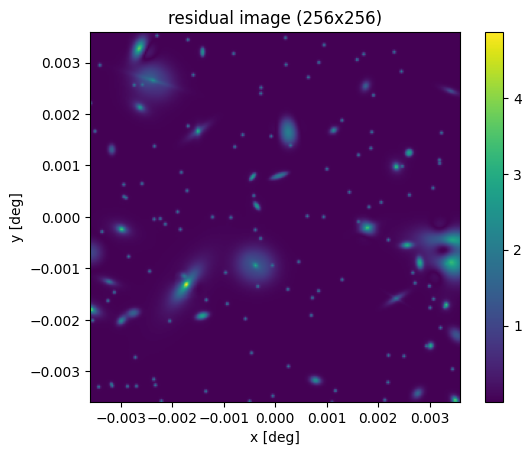

In [426]:
from argosim import metrics_utils 

# compute the metrics

metrics = metrics_utils.compute_metrics(I_clean, sky)
print("metric:", metrics)


# Plot the residual and check the mse

residual_image = metrics_utils.residual(I_clean, sky, True)
plot_utils.plot_sky(residual_image, fov_size=fov_size, title="residual image")

mse_value=metrics_utils.mse(I_clean, sky)
print(f"MSE: {mse_value:.3f}")

# Verify that the mse is the mean of the squared residuals

mse_manual = np.mean(residual_image ** 2)

print(f"MSE (manual): {mse_manual:.3f}")

#checking the equality between the two values

assert np.isclose(mse_value, mse_manual), "False"

print("True")


In [427]:
print("Total flux in observation:", np.sum(obs))
print("Total flux in cleaned image:", np.sum(I_clean))


Total flux in observation: 8142.6804387500015
Total flux in cleaned image: 1647.866311653843


- AUTRE ALGORITHME 

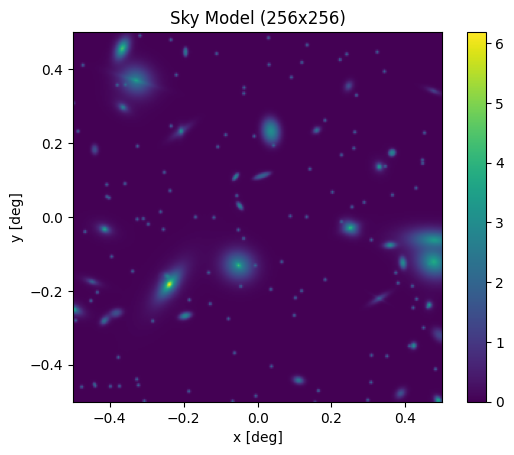

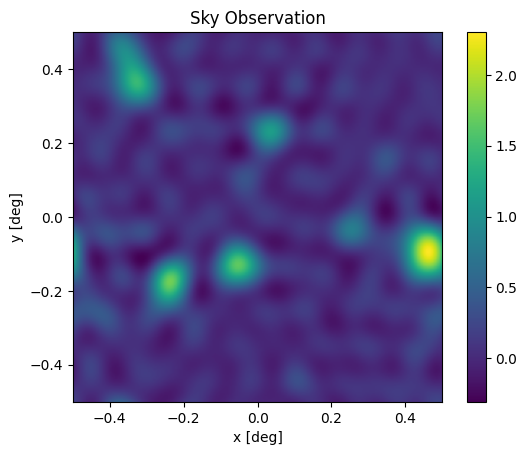

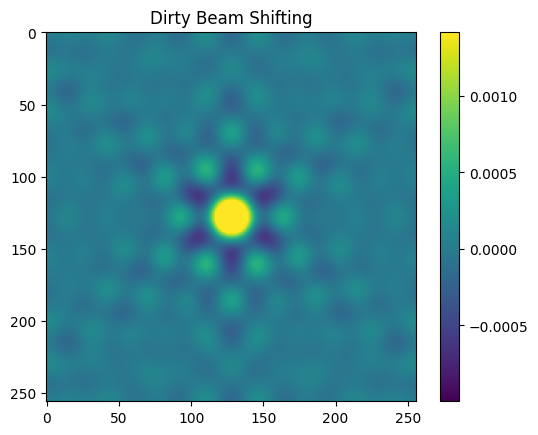

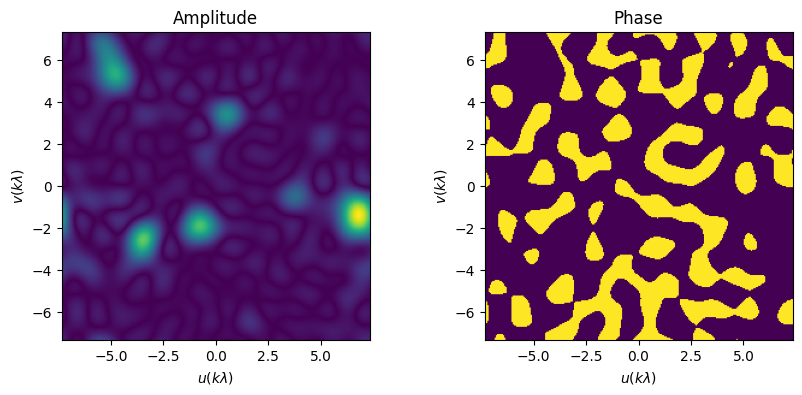

Reached threshold at iteration 33
Metric CLEAN: {'mse': np.float64(0.16043471541440196), 'residual': array([[2.92963372e-03, 3.00650857e-03, 3.14663234e-03, ...,
        3.10126114e+00, 2.03776884e+00, 9.27197635e-01],
       [3.23743210e-03, 3.90755385e-03, 4.44134185e-03, ...,
        3.17907643e+00, 1.89661300e+00, 7.80535936e-01],
       [3.77506041e-03, 3.98417376e-03, 4.39477433e-03, ...,
        2.28680110e+00, 1.22612262e+00, 5.15729725e-01],
       ...,
       [5.28052391e-04, 5.08275523e-04, 5.54958475e-04, ...,
        9.55885916e-05, 8.40953871e-05, 8.66183909e-05],
       [4.53655462e-04, 4.61452029e-04, 4.90088132e-04, ...,
        9.28360678e-05, 8.81142478e-05, 8.62411180e-05],
       [3.86424712e-04, 4.20083059e-04, 4.39884345e-04, ...,
        8.96411002e-05, 8.65269612e-05, 8.57786217e-05]], shape=(256, 256))}
MSE CLEAN: 0.160
MSE (manual) CLEAN: 0.160
MSE comparison TRUE
Metric Richardson-Lucy: {'mse': np.float64(0.1849734545680764), 'residual': array([[2.92963372e-

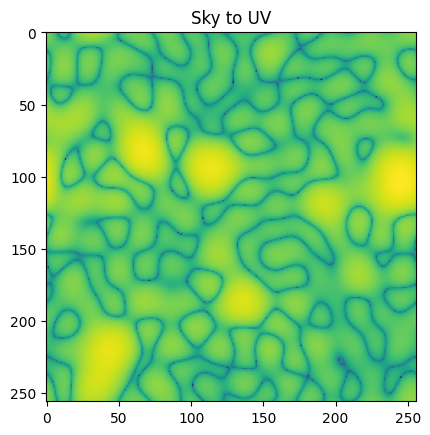

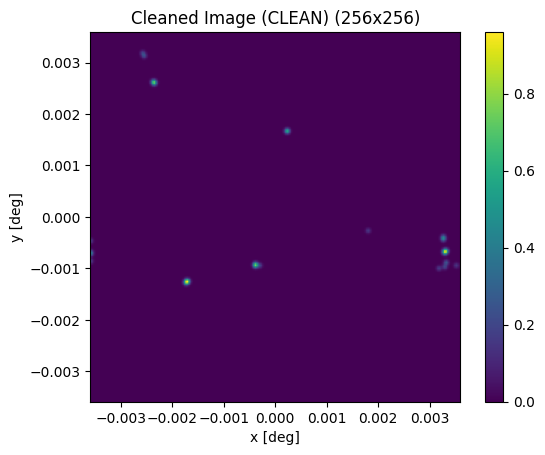

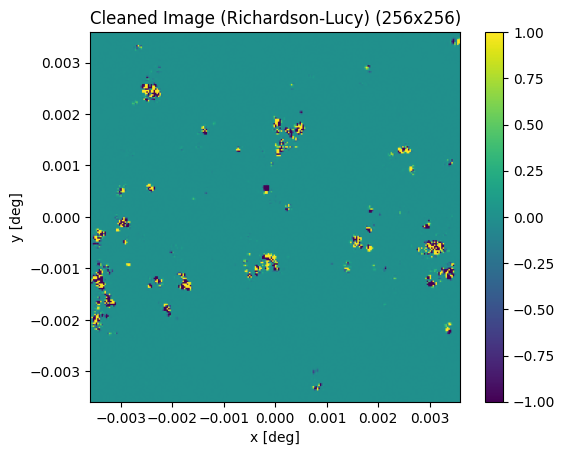

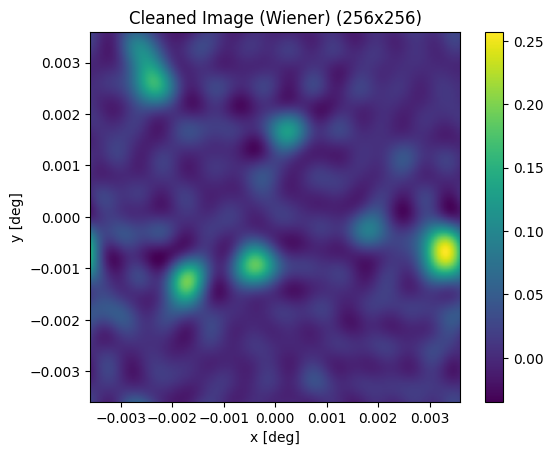

In [428]:
from argosim import *
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import richardson_lucy
from skimage.restoration import wiener
from skimage.filters import gaussian

# 1️⃣ **Obtenir le modèle de ciel et la taille du champ de vision**
sky = dataset['image']  # Récupérer l'image du ciel
fov_size = np.sqrt(dataset['field_area_arcmin2']) / 60.0  # Assurez-vous que c'est une seule valeur numérique (en degrés)

# Convertir fov_size en tuple
fov_size = (fov_size, fov_size)  # Assurez-vous que c'est un tuple (fov_x, fov_y)

# 2️⃣ **Configuration de l'array d'antennes, calcul des baselines et des tracks uv**
antena = antenna_utils.y_antenna_arr(n_antenna=30, r=10e3)  # Array d'antennes
baselines = antenna_utils.get_baselines(antena)  # Calcul des baselines
track, _ = antenna_utils.uv_track_multiband(baselines)  # Calcul des tracks uv

# 3️⃣ **Effectuer l'observation**
obs, dirty_beam = imaging_utils.simulate_dirty_observation(sky, track, fov_size[0])  # Observation sale (dirty image)

# Visualiser le modèle de ciel
plot_utils.plot_sky(sky, title="Sky Model")

# Visualiser l'image sale (dirty image)
plot_utils.plot_sky(obs)
plt.title('Sky Observation')

# Visualiser le dirty beam
dirty_beam_shifted = np.fft.fftshift(dirty_beam)
plot_utils.plot_beam(dirty_beam_shifted)
plt.title('Dirty Beam Shifting')

# Visualiser l'image en uv
plot_utils.plot_sky_uv(obs, fov_size=(1.0, 1.0))
plt.title('Sky to UV')

# Logarithme de l'amplitude pour mieux visualiser les valeurs faibles
plt.imshow(np.log(np.abs(obs)))

# 4️⃣ **Déconvolution avec CLEAN**
I_clean, _ = clean_hogbom(obs, dirty_beam, gamma=0.2, max_iter=100, threshold=1e-3, clean_beam_size_px=3)

# Visualiser l'image nettoyée (CLEAN)
plot_utils.plot_sky(I_clean, fov_size=fov_size, title="Cleaned Image (CLEAN)")

# 5️⃣ **Déconvolution avec Richardson-Lucy**
I_richardson_lucy = richardson_lucy(obs, dirty_beam, num_iter=40)

# Visualiser l'image nettoyée avec Richardson-Lucy
plot_utils.plot_sky(I_richardson_lucy, fov_size=fov_size, title="Cleaned Image (Richardson-Lucy)")

# 6️⃣ **Déconvolution avec Wiener**
psf = gaussian(np.ones((3, 3)), sigma=1)
I_wiener = wiener(obs, psf ,balance=0.1 )  # Filtrage Wiener avec un noyau de taille 3x3

# Visualiser l'image nettoyée avec Wiener
plot_utils.plot_sky(I_wiener, fov_size=fov_size, title="Cleaned Image (Wiener)")

# 7️⃣ **Calculer les métriques pour évaluer les images nettoyées**
metrics = metrics_utils.compute_metrics(I_clean, sky)  # Comparaison CLEAN vs modèle du ciel
print("Metric CLEAN:", metrics)

# Calculer l'erreur quadratique moyenne (MSE) pour CLEAN
mse_value = metrics_utils.mse(I_clean, sky)
print(f"MSE CLEAN: {mse_value:.3f}")

# Calculer l'erreur quadratique moyenne manuellement pour CLEAN
residual_image = metrics_utils.residual(I_clean, sky, True)
mse_manual = np.mean(residual_image ** 2)
print(f"MSE (manual) CLEAN: {mse_manual:.3f}")

# Vérifier que les deux MSE sont égaux
assert np.isclose(mse_value, mse_manual), "False"
print("MSE comparison TRUE")

# Calculer et afficher les métriques pour Richardson-Lucy
metrics_richardson = metrics_utils.compute_metrics(I_richardson_lucy, sky)
print("Metric Richardson-Lucy:", metrics_richardson)

# Calculer l'erreur quadratique moyenne (MSE) pour Richardson-Lucy
mse_value_richardson = metrics_utils.mse(I_richardson_lucy, sky)
print(f"MSE Richardson-Lucy: {mse_value_richardson:.3f}")

# Calculer l'erreur quadratique moyenne manuellement pour Richardson-Lucy
residual_image_richardson = metrics_utils.residual(I_richardson_lucy, sky, True)
mse_manual_richardson = np.mean(residual_image_richardson ** 2)
print(f"MSE (manual) Richardson-Lucy: {mse_manual_richardson:.3f}")

# Vérifier que les deux MSE sont égaux
assert np.isclose(mse_value_richardson, mse_manual_richardson), "False"
print("MSE comparison TRUE")


In [429]:
from skimage.restoration import richardson_lucy
from skimage.restoration import wiener
help(wiener)


Help on function wiener in module skimage.restoration.deconvolution:

wiener(image, psf, balance, reg=None, is_real=True, clip=True)
    Wiener-Hunt deconvolution
    
    Return the deconvolution with a Wiener-Hunt approach (i.e. with
    Fourier diagonalisation).
    
    Parameters
    ----------
    image : ndarray
       Input degraded image (can be n-dimensional).
    psf : ndarray
       Point Spread Function. This is assumed to be the impulse
       response (input image space) if the data-type is real, or the
       transfer function (Fourier space) if the data-type is
       complex. There is no constraints on the shape of the impulse
       response. The transfer function must be of shape
       `(N1, N2, ..., ND)` if `is_real is True`,
       `(N1, N2, ..., ND // 2 + 1)` otherwise (see `np.fft.rfftn`).
    balance : float
       The regularisation parameter value that tunes the balance
       between the data adequacy that improve frequency restoration
       and the prior 

Check the source code of the function `simulate_dirty_observation`. What does it do? And which other functions from the `imaging_utils` module does it use?

...

- simulate_dirty_observation simulates a radio observation of the given sky model, using sample points in UV space. It applies Gaussian noise and can handle multi-frequency observations

- imaging_utils :

sky2uv(sky): to transform the sky image into UV space

compute_visibilities_grid(): to calculate visibilities in UV space

uv2sky(): to reconstruct the image from UV space


In the source code, what does `vis` stand for? Explain...

...

vis is an abbreviation for visibilities. These are the measurements obtained in UV space, which correspond to the Fourier transform of the sky observed by the interferometer.